## Climate Change Belief Analysis
### By Team_JS_2_EDSA

# 1: Introduction

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

This predict layout as follows:

    1. Introduction
    2. Import libraries and load data
    3. Data pre-processing
    4. Exploratory Data Analysis
    5. Building models
    6. Best model
    7. Conclusion
    8. Submission

# 2: Import libraries and load data

In [1]:
from comet_ml import Experiment

In [120]:
# Run to allow Comet to log the parameters of the models and output of cells.
experiment = Experiment(api_key="amGQj1TC3Wyk9LYf7bD9xNV6G",
                        project_name="classification-predict",
                        workspace="daniel-bru",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/daniel-bru/classification-predict/3c872cad52b846d0977d9d93ef2bcb52



In [206]:
# Standard
import pandas as pd
import numpy as np
import time
import seaborn as sns
sns.set(font_scale=1.4)
import matplotlib.pyplot as plt
%matplotlib inline

# Natural language Processing
import re
import nltk
import spacy
import string
from sklearn.utils import resample
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, StackingClassifier

# Performance
from sklearn.metrics import f1_score
from sklearn import metrics

# Exploratory Data Analysis
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

# Saving
import pickle
import joblib

## The data

The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018!

In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes: 2, 1, 0, -1

**Class Description:**

- 2 News: the tweet links to factual news about climate change

- 1 Pro: the tweet supports the belief of man-made climate change

- 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change

- -1 Anti: the tweet does not believe in man-made climate change Variable definitions

**Columns:**

- sentiment: Sentiment of tweet

- message: Tweet body

- tweetid: Twitter unique id

In [178]:
#Loading data and view first few rows
pd.set_option('display.max_colwidth', None)
train = pd.read_csv("train.csv")
test = pd.read_csv("test_with_no_labels.csv")

In [179]:
train

,sentiment,message,tweetid
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954
...,...,...,...
15814,1,"RT @ezlusztig: They took down the material on global warming, LGBT rights, and health care. But now they're hocking Melania's QVC. https://…",22001
15815,2,RT @washingtonpost: How climate change could be breaking up a 200-million-year-old relationship https://t.co/rPFGvb2pLq,17856
15816,0,notiven: RT: nytimesworld :What does Trump actually believe about climate change? Rick Perry joins other aides in … https://t.co/0Mp2,384248
15817,-1,RT @sara8smiles: Hey liberals the climate change crap is a hoax that ties to #Agenda2030.\nThe Climate is Being Changed byÃ¢â‚¬Â¦,819732


In [180]:
test

,message,tweetid
0,Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq,169760
1,Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj,35326
2,"The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax,476263
4,RT @FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican,872928
...,...,...
10541,"RT @BrittanyBohrer: Brb, writing a poem about climate change. #climatechange #science #poetry #fakenews #alternativefacts https://t.co/RpUs…",895714
10542,"2016: the year climate change came home: During the hottest year on record, Karl Mathiesen travelled to Tasmania… https://t.co/WwSrJQfvMg",875167
10543,RT @loop_vanuatu: Pacific countries positive about Fiji leading the global climate change conference in November. https://t.co/PIPRndhkYd,78329
10544,"RT @xanria_00018: You’re so hot, you must be the cause for global warming. #ALDUBLaborOfLove @jophie30 @asn585",867455


In [143]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


# 3: Preprocessing

## 3.1 - Let's do some data cleaning

Function for cleaning the data:

* Remove punctuations 
* Remove stop words
* Lemmitazation 

In [181]:
def clean_tweets(message, remove_stopwords=False):
    """
    A function to preprocess tweets for model training and exploratory data analysis
    :param message: String, to be cleaned
    :param remove_stopwords: Bool, defualt is False, set to true if using message for EDA
    return: String, message
    """    

    # change all words into lower case
    message = message.lower()

    # replace all url-links with url-web
    url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    message = re.sub(url, 'web', message)
    # removing all punctuation and digits
    message = re.sub(r'[-]',' ',message)
    message = re.sub(r'[_]', ' ', message)
    message = re.sub(r'[^\w\s]','',message)
    message = re.sub('[0-9]+', '', message) 
    message = re.sub(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~âã¢¬¦¢’‘‚…]', ' ', message)
    message = re.sub("â|ã", " ", message)  # removes strange character 
    message = re.sub("\\s+", " ", message)  # fills white spaces
    message = message.lstrip()  # removes whitespaces before string
    message = message.rstrip()  # removes whitespaces after string 
    
    # remove stopwords if wordcloud
    if remove_stopwords == True:         
        stop_words = stopwords.words('english')
        stop_words.append('web')
        stop_words.append('climate')
        stop_words.append('change')
        stop_words.append('global')
        stop_words.append('warming')
        stop_words.append('rt')
        stop_words.append('u')
        message = ' '.join([word for word in message.split(' ') if not word in stop_words])
        
        
    # lemmatizing all words
    message = message.lower()
    lemmatizer = WordNetLemmatizer()
    message = [lemmatizer.lemmatize(token) for token in message.split(" ")]
    message = [lemmatizer.lemmatize(token, "v") for token in message]
    message = " ".join(message)

    return message

In [182]:
%%time
#Apply the clean function to our train and test data
train['message_clean']=train['message'].apply(clean_tweets)

test['message_clean']=test['message'].apply(clean_tweets)

Wall time: 5.78 s


In [183]:
#Data after clean: Train
train[train['sentiment']==2].head(50)

,sentiment,message,tweetid,message_clean
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,rt rawstory researcher say we have three year to act on climate change before it too late web web
12,2,"RT @tveitdal: We only have a 5 percent chance of avoiding ‘dangerous’ global warming, a study finds https://t.co/xUBTqNxhkK https://t.co/of…",454673,rt tveitdal we only have a percent chance of avoid dangerous global warm a study find web web
14,2,"Fossil fuel giant ExxonMobil ‘misled’ the public about climate change, Harvard academics conclude https://t.co/ofc2WSu4EX",658092,fossil fuel giant exxonmobil mislead the public about climate change harvard academic conclude web
26,2,Bangladesh confronting climate change head on https://t.co/MTqeNBQDUt https://t.co/itgkUxgEfg,365291,bangladesh confront climate change head on web web
32,2,RT @latimes: Atmospheric rivers fueled by climate change could decimate wild oysters in San Francisco Bay https://t.co/p0LZBhlU5K https://t…,143471,rt latimes atmospheric river fuel by climate change could decimate wild oyster in san francisco bay web web
36,2,RT @Independent: Trump's team removed climate change data from the White House website. They may be breaking the law…,526603,rt independent trump team remove climate change data from the white house website they may be break the law
41,2,2050 climate targets: nations are playing the long game in fighting global warming https://t.co/dnegw2vfJd via @ConversationEDU,8984,climate target nation be play the long game in fight global warm web via conversationedu
44,2,"RT @washingtonpost: The Alaskan tundra is filling the atmosphere with carbon dioxide, worsening climate change https://t.co/nSOimuwEax",905639,rt washingtonpost the alaskan tundra be fill the atmosphere with carbon dioxide worsen climate change web
45,2,RT @TheTorontoSun: From @sunlorrie: Indian environmentalist calls out DiCaprio in his own documentary on climate change.Ã¢â‚¬Â¦,741568,rt thetorontosun from sunlorrie indian environmentalist call out dicaprio in his own documentary on climate change
49,2,"RT @Starbuck: World food supplies at risk as #climate change threatens international trade, warn experts https://t.co/rWCW2XF2lr https://t.…",499888,rt starbuck world food supply at risk a climate change threaten international trade warn expert web web


In [184]:
#Data after clean: Test
test.head()

,message,tweetid,message_clean
0,Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq,169760,europe will now be look to china to make sure that it be not alone in fight climate change web
1,Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj,35326,combine this with the poll of staffer re climate change and woman right and you have a fascist state web
2,"The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..",224985,the scary unimpeachable evidence that climate change be already here web itstimetochange climatechange zeroco
3,@Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax,476263,karoli morgfair osborneink dailykos putin get to you too jill trump doesnt believe in climate change at all think it s hoax
4,RT @FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican,872928,rt fakewillmoore female orgasm cause global warm sarcastic republican


## 3.2 - Let's see if there is a imbalance in the data

In [185]:
#Count of data entries for different sentiments
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

<AxesSubplot:title={'center':'Class Distribution'}, xlabel='sentiment', ylabel='count'>

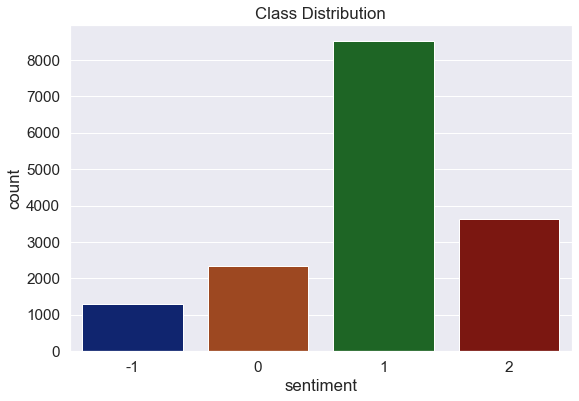

In [186]:
#View class distribution to confirm balance/imbalance
fig, ax = plt.subplots(figsize=(9,6))
plt.title('Class Distribution')
sns.countplot(data = train, x = train['sentiment'],  palette= 'dark')

## Balancing the data

There is a different ways of balancing data:

- 1: Resampling
- 2: SMOTE

In [187]:
#Applying each sentiment to their own data frame
news = train[train['sentiment'] == 2]
pro = train[train['sentiment'] == 1]
neutral = train[train['sentiment'] == 0]
anti = train[train['sentiment'] == -1]

In [188]:
#Applying the resampling method to the data
news_upsampled = resample(news, replace=True, n_samples=len(pro), random_state=27)
neutral_upsampled = resample(neutral, replace=True, n_samples=len(pro), random_state=27)
anti_upsampled = resample(anti, replace=True, n_samples=len(pro), random_state=27)

**Combine majority and new upsampled minority**

In [189]:
#New upsampled train dataframe
df_upsampled = pd.concat([pro, news_upsampled, neutral_upsampled, anti_upsampled])

In [190]:
df_upsampled.sentiment.value_counts()

 0    8530
 1    8530
 2    8530
-1    8530
Name: sentiment, dtype: int64

<AxesSubplot:title={'center':'Class Distribution after Upsampling'}, xlabel='sentiment', ylabel='count'>

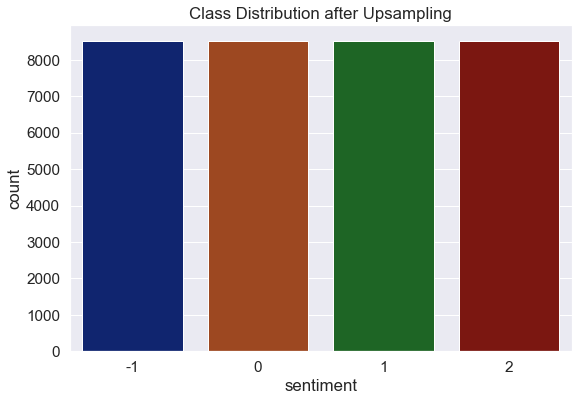

In [191]:
fig, ax = plt.subplots(figsize=(9,6))
plt.title('Class Distribution after Upsampling')
sns.countplot(data = df_upsampled, x= df_upsampled['sentiment'], palette= 'dark')

In [192]:
df_upsampled

,sentiment,message,tweetid,message_clean
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,polyscimajor epa chief doesnt think carbon dioxide be main cause of global warm and wait what web via mashable
1,1,It's not like we lack evidence of anthropogenic global warming,126103,it not like we lack evidence of anthropogenic global warm
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,todayinmaker wire wa a pivotal year in the war on climate change web
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,rt soynoviodetodas it and a racist sexist climate change deny bigot be lead in the poll electionnight
5,1,Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j,425577,worth a read whether you do or dont believe in climate change web web
...,...,...,...,...
5422,-1,RT @worldnetdaily: Sorry global warming liars... Arctic sea ice today is about the same thickness as it was 75 years ago. https://t.co/Br60…,857394,rt worldnetdaily sorry global warm liar arctic sea ice today be about the same thickness a it wa year ago web
11148,-1,RT @charlesadler: #Trudeau gov now admitting long term climate change strategy may include burning tax $$$ to buy carbon credits. https://t…,509562,rt charlesadler trudeau gov now admit long term climate change strategy may include burn tax to buy carbon credit web
11428,-1,That would be a natural storm and of course poor government energy management driven by climate change fanatics… https://t.co/gZUwDFoR9l,158073,that would be a natural storm and of course poor government energy management drive by climate change fanatic web
1341,-1,RT @TheFoundingSon: NOAA scientists manipulated temperature data to make global warming seem worse\n\nWho's surprised? Not me\nhttps://t.co/Rj…,905959,rt thefoundingson noaa scientist manipulate temperature data to make global warm seem worse who surprise not me web


# 4: Exploratory Data Analysis

- Make use of seaborn, wordcloud and matplotlib

### Message Lenghth

In [193]:
train['length'] = train['message'].apply(len)

<AxesSubplot:title={'center':'Message Length Distribution'}, xlabel='length', ylabel='Count'>

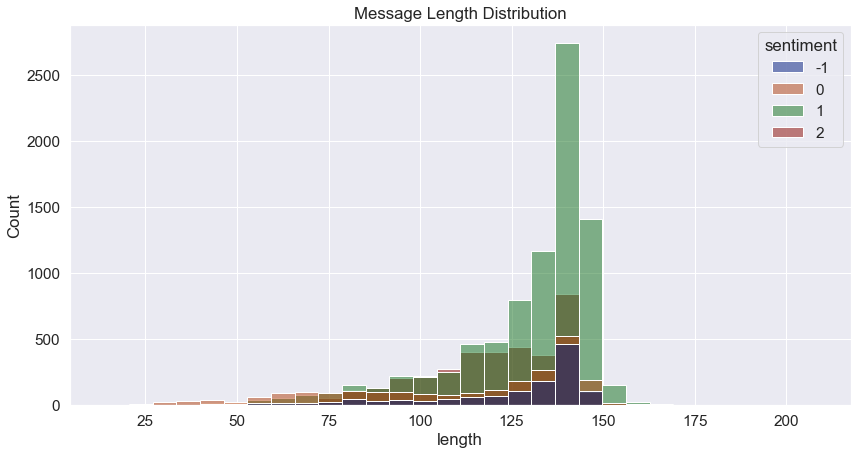

In [194]:
fig, ax = plt.subplots(figsize=(14,7))
plt.title('Message Length Distribution')
sns.histplot(data=train, x= 'length', bins=30, kde=False, ax= ax, hue= 'sentiment', palette= 'dark')

## 4.1: Extract Hashtags

In [195]:
def hashtag_extract(x):
    """
    Function to extract the hashtags from the messages column
    """
    hashtags = []    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [196]:
# extracting hashtags from train tweets
anti_hashtag = hashtag_extract(train['message'][train['sentiment'] == -1])
neutral_hashtag = hashtag_extract(train['message'][train['sentiment'] == 0])
pro_hashtag = hashtag_extract(train['message'][train['sentiment'] == 1])
news_hashtag = hashtag_extract(train['message'][train['sentiment'] == 2])

# unnesting list
anti_hashtag= sum(anti_hashtag,[])
neutral_hashtag = sum(neutral_hashtag,[])
pro_hashtag = sum(pro_hashtag,[])
news_hashtag = sum(news_hashtag,[])

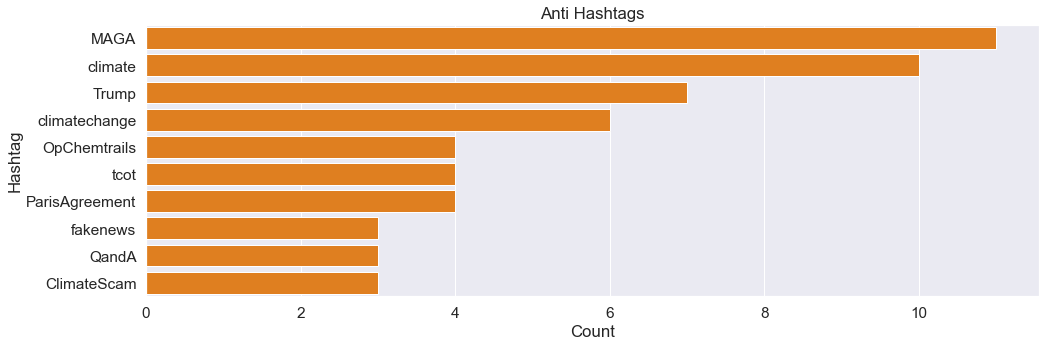

In [197]:
#creating a frequency distribution of the hashtags
v = nltk.FreqDist(anti_hashtag)
k = pd.DataFrame({'Hashtag': list(v.keys()),
                  'Count': list(v.values())})

# selecting top 10 most frequent hashtags     
k = k.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=k, x= "Count", y = "Hashtag", color ='#ff7f00')
ax.set(xlabel = 'Count', title= 'Anti Hashtags')
plt.show()

## 4.2: Extract Frequently used words

In [198]:
# prep data for eda by removing stop words
train['message_clean_eda']=train['message'].apply(lambda x: clean_tweets(message =x, remove_stopwords=True))

In [199]:
news_tweets = ' '.join([text for text in train['message_clean_eda']
                        [train['sentiment'] == 2]])
pro_tweets = ' '.join([text for text in train['message_clean_eda']
                       [train['sentiment'] == 1]])
neutral_tweets = ' '.join([text for text in train['message_clean_eda']
                           [train['sentiment'] == 0]])
anti_tweets = ' '.join([text for text in train['message_clean_eda']
                        [train['sentiment'] == -1]])

In [200]:
full_title = ['Popular words for News tweets',
              'Popular words for Pro tweets',
              'Popular words for Neutral tweets',
              'Popular words for Anti tweets']
tweet_list = [news_tweets, pro_tweets,neutral_tweets, anti_tweets]

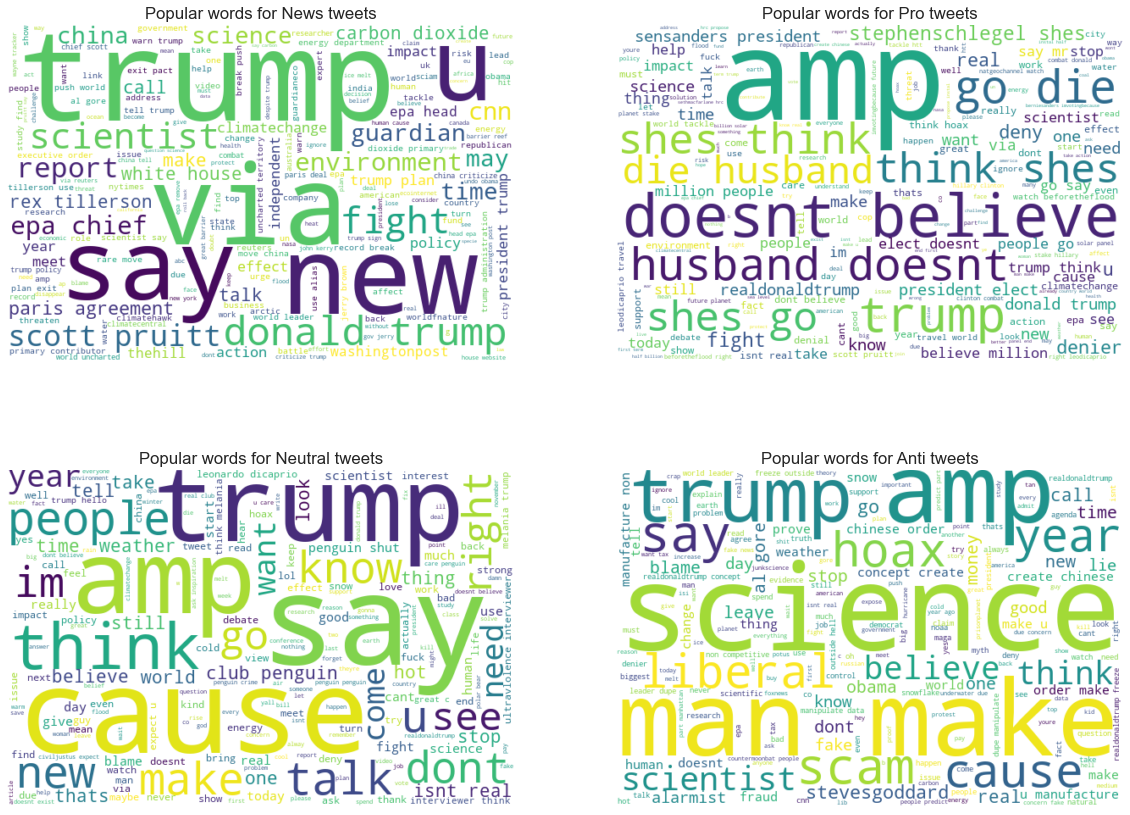

In [205]:
# Create word clouds of the most common words in each sentiment class
wc = WordCloud(width=600, height=400, 
               background_color='white',
               max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots 

for i in range(0, len(tweet_list)):
    wc.generate(tweet_list[i])
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(full_title[i])
    
plt.show()

## 4.3: Named entity extraction 

# 5: Modeling

Here we can decide to use one of two dataframes:

- 1: Normal clean train dataframe(train)
- 2: Balanced clean train dataframe(df_upsampled)

## Model Information:

**Model 1: Linear Support Vector Classifier**
- The objective of a Linear SVC (Support Vector Classifier) is to fit to the data provided, returning a "best fit" hyperplane that divides, or categorizes, data. After getting the hyperplane,the features are fed to the classifier to see what the "predicted" class is. 

**Model 2: Extra Trees Classifier**
- An extra-trees classifier is a class that implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The number of trees in the forest.

**Model 3: Logistic Regression**
- Logistic regression is basically a supervised classification algorithm. In a classification problem, the target variable(or output), y, can take only discrete values for given set of features(or inputs), X.Just like Linear regression assumes that the data follows a linear function, Logistic regression models the data using the sigmoid function.

**Model 4: Stochastic Gradient Descent (SGD)**
-  SGD is a simple,efficient approach to fitting linear classifiers and regressors under convex loss functions such as (linear) Support Vector Machines and Logistic Regression.It has received a considerable amount of attention just recently in the context of large-scale learning.

**Model 5: Ada Boost Classifier**
-  It combines multiple classifiers to increase the accuracy of classifiers. AdaBoost is an iterative ensemble method. AdaBoost classifier builds a strong classifier by combining multiple poorly performing classifiers so that you will get high accuracy strong classifier. The basic concept behind Adaboost is to set the weights of classifiers and training the data sample in each iteration such that it ensures the accurate predictions of unusual observations.

**Model 6: K-Nearest Neighbors (KNN)**
- In pattern recognition, the k-nearest neighbors algorithm (k-NN) is a non-parametric method proposed by Thomas Cover used for classification and regression. In both cases, the input consists of the k closest training examples in the feature space. ... In k-NN classification, the output is a class membership.

**Model 7: Multi Nomial Naive Bayes**
- In summary, Naive Bayes classifier is a general term which refers to conditional independence of each of the features in the model, while Multinomial Naive Bayes classifier is a specific instance of a Naive Bayes classifier which uses a multinomial distribution for each of the features

**Model 8: Ridge Classifier**
- The Ridge Classifier, based on Ridge regression method, converts the label data into [-1, 1] and solves the problem with regression method. The highest value in prediction is accepted as a target class and for multiclass data muilti-output regression is applied.

**Model 9: Random Forest Classifier**
- The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

In [ ]:
X = train['message_clean']
y = train['sentiment'] 

X_train , X_test , y_train , y_test = train_test_split(X , y, test_size =0.05, random_state =42)

In [69]:
classifiers = [
               LinearSVC(random_state=42),
               ExtraTreesClassifier(),
               LogisticRegression(random_state=42, n_jobs=1, max_iter=5000),
               SGDClassifier(),
               AdaBoostClassifier(),
               KNeighborsClassifier(),
               MultinomialNB(),
               RidgeClassifier(),
               RandomForestClassifier()
    ]


In [70]:
def model_assessment(classifiers, X_train, y_train, X_test, y_test):
    """
    A function to train and test different classifiers and return a performance summary. 
    :param classifiers: List of models
    return: Dataframe of models as index, and metrics as columns
    """  
    model_summary = {}
    
    # Pipeline to balance the classses and then to build the model
    for clf in classifiers:
        model = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))),
                    ('clf',clf)
                          ])

    # Execution Time Logging
        start_time = time.time()
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        run_time = time.time()-start_time
      
    # Models Performance
        model_summary[clf.__class__.__name__] = {
          'F1-Macro':metrics.f1_score(y_test,predictions,average='macro'),
          'F1-Accuracy':metrics.f1_score(y_test,predictions,average='micro'),
          'F1-Weighted':metrics.f1_score(y_test,predictions,average='weighted'),
          'Execution Time': run_time }
      
        
    return pd.DataFrame.from_dict(model_summary, orient='index')

In [71]:
%%time
clf_performance_df = model_assessment(classifiers,X_train, y_train, X_test, y_test)
ordered_clf_performance_df = clf_performance_df.sort_values('F1-Weighted',ascending=False)
ordered_clf_performance_df

COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Wall time: 2min 28s


,F1-Macro,F1-Accuracy,F1-Weighted,Execution Time
LinearSVC,0.706003,0.786346,0.773145,1.335453
RidgeClassifier,0.686667,0.774968,0.758995,1.202842
SGDClassifier,0.670172,0.769912,0.751909,1.241481
LogisticRegression,0.649375,0.756005,0.738006,15.827552
ExtraTreesClassifier,0.628157,0.734513,0.717859,79.136315
RandomForestClassifier,0.603440,0.705436,0.694623,43.302055
KNeighborsClassifier,0.605026,0.672566,0.668443,1.407305
AdaBoostClassifier,0.503308,0.639697,0.608199,4.191424
MultinomialNB,0.388446,0.658660,0.573410,0.827890


<AxesSubplot:>

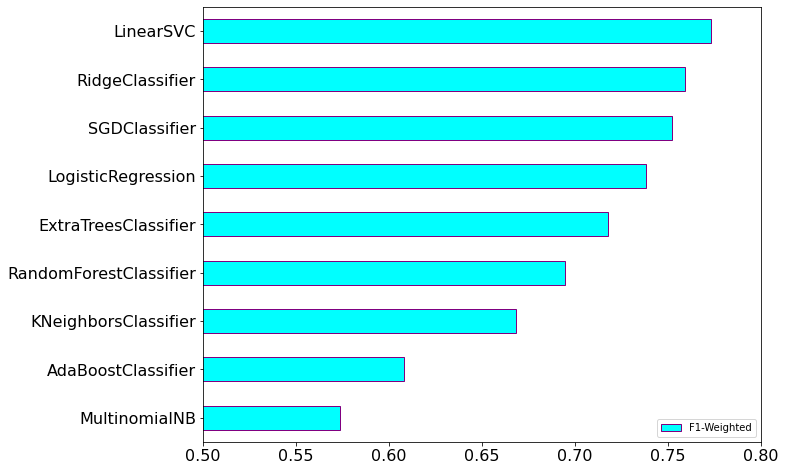

In [244]:
# Plot the results
ordered_clf_performance_df.sort_values('F1-Weighted',ascending=True).plot(y='F1-Weighted', 
                                                            kind='barh', 
                                                            xlim=[0.5, 0.8], 
                                                            color= 'cyan', 
                                                            edgecolor = 'purple',
                                                            figsize=(10, 8), 
                                                            fontsize=16)


In [27]:
#Function to fit/test classifiers and return a performance summary                                             
def model_assessment_CV(X,y):
    """
    A function to perform Cross Validation on list of different classifiers and return a performance summary. 
    :param X: Feature data
    :param y: Target data
    return: Dataframe of models as index, and metrics as columns
    """    
    model_summary = []
    
    for clf in classifiers:
        model = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))),
                    ('clf',clf)
                          ])

    # Execution Time Logging
        start_time = time.time()
        scores = cross_val_score(model, X=X, y=y, cv=5)
        run_time = time.time()-start_time
        model_summary.append([clf.__class__.__name__, scores.mean(), scores.std(), run_time])
    
    performace_summary = pd.DataFrame(model_summary, columns=['Model', 'CV_Mean', 'CV_Std','Execution Time'])
    performace_summary.set_index('Model', inplace=True)
 
    return performace_summary

In [28]:
%%time
CV_clf_performance_df = model_assessment_CV(X,y)

In [61]:
ordered_CV_clf_performance_df = CV_clf_performance_df.sort_values('CV_Mean',ascending=False)

In [62]:
# Save the results so we dont have to run it again
ordered_CV_clf_performance_df.to_csv('ordered_CV_clf_performance_df.csv')

In [202]:
ordered_CV_clf_performance_df = pd.read_csv('ordered_CV_clf_performance_df.csv', index_col = 'Model')
ordered_CV_clf_performance_df

,CV_Mean,CV_Std,Execution Time
Model,,,
LinearSVC,0.753904,0.007763,5.458754
RidgeClassifier,0.749985,0.008328,9.932733
SGDClassifier,0.744675,0.007363,9.578883
LogisticRegression,0.728744,0.008132,78.864897
ExtraTreesClassifier,0.722612,0.008042,280.153271
RandomForestClassifier,0.697074,0.008338,290.783042
KNeighborsClassifier,0.643783,0.005295,24.445339
MultinomialNB,0.638283,0.003658,7.435782
AdaBoostClassifier,0.630192,0.008455,34.111243


<AxesSubplot:ylabel='Model'>

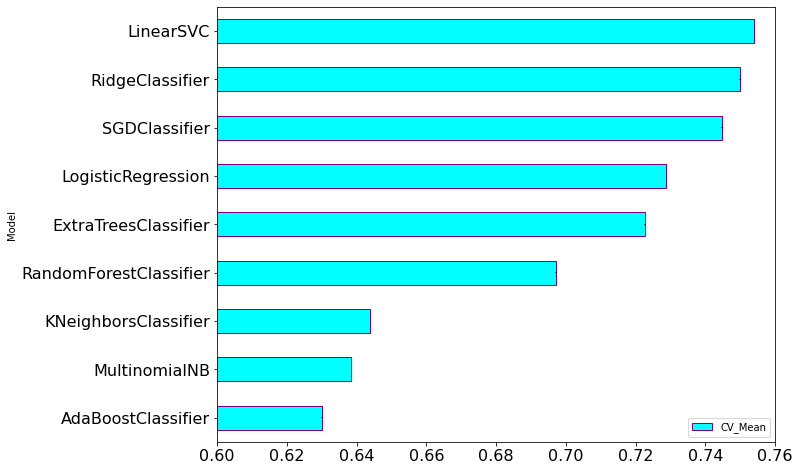

In [245]:
# Plot the results
ordered_CV_clf_performance_df.sort_values('CV_Mean',ascending=True).plot(y='CV_Mean', \
                                                                yerr='CV_Std', 
                                                                kind='barh', 
                                                                xlim=[0.6, 0.76],
                                                                color= 'cyan', 
                                                                edgecolor = 'purple',        
                                                                figsize=(10, 8), 
                                                                fontsize=16)

## 5.1: Hyperparameter Tuning


Let's tune the hyperparameters of our 4 best models to improve their ability to classify the tweets. 

In [7]:
classifiers = [
               LinearSVC(random_state=42),
               LogisticRegression(random_state=42, n_jobs=1, max_iter=5000),
               SGDClassifier(),
               RidgeClassifier()
    ]

First, let's define a function to see what their current hyperparameters are.

In [27]:
def get_hyperparams(classifiers, X_train, y_train):
    """
    A function to train different classifiers and return their parameters.
    :classifiers: List of models
    return: Dictionary with model names as keys and the values are a dictionary with parameter names as keys 
            and parameter value as values.
    """  
    model_params = {}
  
    for clf in classifiers:
        model = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))),
                    ('clf',clf)
                          ])
        
        model.fit(X_train, y_train)
        
        params = model.get_params()
        model_name = clf.__class__.__name__ 
        model_name = {}
        
        for key in params:
            if key.startswith("clf"):
                if len(key) < 5:
                    model_name['model'] = params[key]
                else:
                    model_name[key[5:]] = params[key]
        
        model_params[clf.__class__.__name__] = model_name
        
    return model_params

In [17]:
X = train['message_clean']
y = train['sentiment'] 

X_train , X_test , y_train , y_test = train_test_split(X , y, test_size =0.05, random_state =42)

In [18]:
%%time
model_params = get_hyperparams(classifiers, X_train, y_train)

In [19]:
model_params[classifiers[0].__class__.__name__]  # classifiers[0] == LinearSVC

{'model': LinearSVC(random_state=42),
 'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

##  Grid Search CV

We'll use GridSearchCV to tune the hyperparamerts of our models.

In [108]:
# Prep the data
X = train['message_clean']
y = train['sentiment'] 

vect = TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))
X_vectorized = vect.fit_transform(X)

X_train , X_test , y_train , y_test = train_test_split(X_vectorized, y, test_size=0.05, random_state =42)

### Ridge Classifier

In [166]:
#Current Hyperparameters
model_params[classifiers[3].__class__.__name__]

{'model': RidgeClassifier(),
 'alpha': 1.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [61]:
%%time
# define model and params

model = RidgeClassifier()
alpha = list(np.linspace(0.17,0.24,8))
class_weight = [None]


grid = dict(alpha=alpha, class_weight=class_weight)

cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=4, random_state=1)

ridge = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)
f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
f1_weighted = metrics.f1_score(y_test, y_pred, average='weighted')

experiment.log_dataset_hash(X_train)
experiment.log_parameters({"model_type": "Ridge Classifier", "param_grid": grid})
experiment.log_metrics({'F1 Macro': f1_macro, "Accuracy": f1_weighted})

Wall time: 1min 46s


In [62]:
print(ridge.best_score_)
print(ridge.best_params_) 
print(ridge.best_estimator_) 

0.7445604265377659
{'alpha': 0.24, 'class_weight': None}
RidgeClassifier(alpha=0.24)


### Logistic Regression

In [177]:
#Current Hyperparameters
model_params[classifiers[1].__class__.__name__]

{'model': LogisticRegression(max_iter=5000, n_jobs=1, random_state=42),
 'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 5000,
 'multi_class': 'auto',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [64]:
%%time
# !!! dont run this cell, takes 1hr22m to execute

# define model and params

model = LogisticRegression()

c_values = [150, 100, 10, 1.0, 0.5]
penalty = ['l2']
solvers = ['lbfgs']
max_iter = [6000, 5000]

grid = dict(solver=solvers, penalty=penalty, C=c_values, max_iter=max_iter)

cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=4, random_state=1)
logistic = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
logistic.fit(X_train, y_train)

y_pred = logistic.predict(X_test)
f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
f1_weighted = metrics.f1_score(y_test, y_pred, average='weighted')


experiment.log_parameters({"model_type": "Logistic Regression", "param_grid": grid})
experiment.log_metrics({'F1 Macro': f1_macro, "Accuracy": f1_weighted})

Wall time: 1h 22min 47s


In [65]:
print(logistic.best_score_)
print(logistic.best_params_) 
print(logistic.best_estimator_) 

0.7445436868541936
{'C': 100, 'max_iter': 6000, 'penalty': 'l2', 'solver': 'lbfgs'}
LogisticRegression(C=100, max_iter=6000)


In [67]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

          -1       0.78      0.46      0.58        61
           0       0.69      0.39      0.50       123
           1       0.78      0.91      0.84       441
           2       0.82      0.83      0.82       166

    accuracy                           0.78       791
   macro avg       0.76      0.65      0.68       791
weighted avg       0.77      0.78      0.76       791

0.7619583543886658


### Stochastic Gradient Descent Classifier

In [185]:
#Current Hyperparameters
model_params[classifiers[2].__class__.__name__]

{'model': SGDClassifier(),
 'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [88]:
%%time
# define model and params
model = SGDClassifier()
alpha = [0.00002, 0.000015, 0.000017, 0.000018]
power_t = [0.32, 0.3, 0.28]
penalty = ['l2']
max_iter = [6000]

# define grid search
grid = dict(penalty=penalty, alpha=alpha, max_iter=max_iter, power_t=power_t)

cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=4, random_state=1)
sgd = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)
f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
f1_weighted = metrics.f1_score(y_test, y_pred, average='weighted')


experiment.log_parameters({"model_type": "Logistic Regression", "param_grid": grid})
experiment.log_metrics({'F1 Macro': f1_macro, "Accuracy": f1_weighted})

Wall time: 39.7 s


In [89]:
print(sgd.best_score_)
print(sgd.best_params_) 
print(sgd.best_estimator_) 

0.7472554292373719
{'alpha': 2e-05, 'max_iter': 6000, 'penalty': 'l2', 'power_t': 0.32}
SGDClassifier(alpha=2e-05, max_iter=6000, power_t=0.32)


In [90]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

          -1       0.75      0.49      0.59        61
           0       0.66      0.41      0.51       123
           1       0.79      0.90      0.84       441
           2       0.81      0.86      0.83       166

    accuracy                           0.78       791
   macro avg       0.75      0.66      0.69       791
weighted avg       0.77      0.78      0.77       791

0.7696406834673507


### Linear SVC 

In [186]:
#Current Hyperparameters
model_params[classifiers[0].__class__.__name__]

{'model': LinearSVC(random_state=42),
 'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

In [115]:
%%time
# define model and params

model = LinearSVC()
C = [1, 1.3]
max_iter = [1000]
class_weight = ['balanced', None]

grid = dict(C=C, max_iter=max_iter, class_weight=class_weight)

cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=4, random_state=1)
lsvc = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
lsvc.fit(X_train, y_train)

y_pred = lsvc.predict(X_test)
f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
f1_weighted = metrics.f1_score(y_test, y_pred, average='weighted')


experiment.log_parameters({"model_type": "Logistic Regression", "param_grid": grid})
experiment.log_metrics({'F1 Macro': f1_macro, "Accuracy": f1_weighted})

Wall time: 51 s


In [116]:
print(lsvc.best_score_)
print(lsvc.best_params_) 
print(lsvc.best_estimator_) 

0.7511315295394302
{'C': 1, 'class_weight': 'balanced', 'max_iter': 1000}
LinearSVC(C=1, class_weight='balanced')


In [117]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

          -1       0.72      0.56      0.63        61
           0       0.64      0.47      0.54       123
           1       0.82      0.86      0.84       441
           2       0.78      0.87      0.82       166

    accuracy                           0.78       791
   macro avg       0.74      0.69      0.71       791
weighted avg       0.77      0.78      0.77       791

0.7724148569820287


In [119]:
experiment.end()

# 5.2: Model Assessment

Let's train our newly tuned models and assess their accuracy.

In [121]:
X = train['message_clean']
y = train['sentiment'] 
X_train , X_test , y_train , y_test = train_test_split(X , y, test_size =0.05, random_state =42)

In [127]:
best_classifiers = [ 
                     LinearSVC(C = 1, max_iter= 1000),
                     LogisticRegression(C= 100, max_iter= 6000, penalty= 'l2', solver= 'lbfgs', n_jobs=1),
                     SGDClassifier(alpha=2e-05, max_iter= 6000, penalty='l2', power_t= 0.32),
                     RidgeClassifier(alpha=0.24)
    ]

In [128]:
%%time
best_performing_df = model_assessment(best_classifiers,X_train, y_train, X_test, y_test)
ordered_best_performing_df = best_performing_df.sort_values('F1-Weighted',ascending=False)
ordered_best_performing_df

Wall time: 55.7 s


,F1-Macro,F1-Accuracy,F1-Weighted,Execution Time
LinearSVC,0.706003,0.786346,0.773145,1.332275
LogisticRegression,0.703153,0.781290,0.770756,51.758541
RidgeClassifier,0.698101,0.780025,0.766939,1.453779
SGDClassifier,0.696902,0.776233,0.764144,1.077737


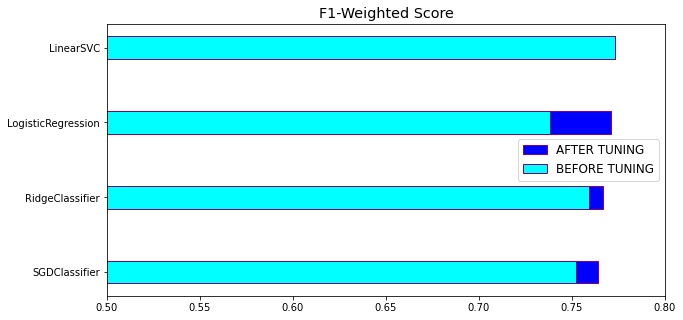

In [246]:
# The results
after = ordered_best_performing_df.sort_values('F1-Weighted',ascending=True)
before = ordered_clf_performance_df.sort_values('F1-Weighted',ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim([0.5, 0.8])
plt.rcParams['font.size'] = '12'

hyperparams_2 = after['F1-Weighted'].index
hyperparams_1 = before['F1-Weighted'].index
f12 = after['F1-Weighted']
f11 = before['F1-Weighted'][hyperparams_2]

after_tuning = ax.barh(y= hyperparams_2, width= f12, height =0.3, color= 'blue', 
                                   edgecolor = 'purple',label = 'AFTER TUNING')
before_tuning = ax.barh(y=hyperparams_2, width= f11, height =0.3, color= 'cyan', 
                        edgecolor = 'purple', label = 'BEFORE TUNING')
ax.set_title('F1-Weighted Score')

ax.legend()
plt.show()

...something about the performance of the models

## 5.3: Best Model

In [8]:
X = train['message_clean']
y = train['sentiment'] 

X_train , X_test , y_train , y_test = train_test_split(X , y, test_size =0.05, random_state =42)

In [11]:
%%time

model = LinearSVC()

#Pipeline for training
model_pipe = Pipeline([
                        ('tfidf', TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))), 
                        ('classification', model) 
                        ])

#Fitting our Linear SVC model
model_pipe.fit(X_train, y_train) 


Wall time: 1.44 s


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, ngram_range=(1, 2),
                                 stop_words='english')),
                ('classification', LinearSVC())])

### After fitting our model now we predict and evaluate our model

In [17]:
y_pred = model_pipe.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
print('f1 score: ', metrics.f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

          -1       0.76      0.56      0.64        61
           0       0.71      0.40      0.51       123
           1       0.80      0.89      0.84       441
           2       0.78      0.89      0.83       166

    accuracy                           0.79       791
   macro avg       0.76      0.68      0.71       791
weighted avg       0.78      0.79      0.77       791

f1 score:  0.7731445060771621


### As we can see our model predicts very accurate on our train test and split data with a +95%, now we will go and use the model on our unseen test data

# 6: Use best model on our test/real word data

## Save the Model

In [9]:
X = train['message_clean']
y = train['sentiment'] 

vect = TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))
X_vect = vect.fit_transform(X)

model = LogisticRegression(C= 100, max_iter= 6000, penalty= 'l2', solver= 'lbfgs', n_jobs=1)

model.fit(X_vect, y) # now we train the model with entire dataset as we've done validation

# Pickle the model
model_save_path = "resources/LogReg.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model,file)
# Pickle the vect
vect_save_path = "resources/TFIDFvect.pkl"
with open(vect_save_path,'wb') as file:
    pickle.dump(vect,file)
print('Saved.')

Saved.


## Prediction time

In [12]:
X = test['message_clean']

# Unpickle, predict

model_load_path = "resources/LogReg.pkl"
with open(model_load_path,'rb') as file:
    model = pickle.load(file)

vect_load_path = "resources/tfidfvect.pkl"
with open(vect_load_path,'rb') as file:
    vect = joblib.load(file)

X_vect = vect.transform(X)

# Predict
test['sentiment'] = model.predict(X_vect)

In [13]:
# Viewing our test data with predicted sentiment
test.head()

,message,tweetid,message_clean,sentiment
0,Europe will now be looking to China to make su...,169760,europe will now be look to china to make sure ...,1
1,Combine this with the polling of staffers re c...,35326,combine this with the poll of staffer re clima...,1
2,"The scary, unimpeachable evidence that climate...",224985,the scary unimpeachable evidence that climate ...,1
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,karoli morgfair osborneink dailykos putin get ...,1
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,rt fakewillmoore female orgasm cause global wa...,0


## Submission


In [14]:
# Submission in kaggle format
submission = test[['tweetid', 'sentiment']]
submission.to_csv('LogisticReg.csv',index=False)

# 7: Conclusion